In [11]:
# Importing the recquired libraries:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from platform import python_version
print(python_version())
print(torch.__version__)

3.6.10
1.1.0


In [12]:
train_set = ['urjc', 'gavab'] * 400
len_train = len(train_set)

In [13]:
# Function to convert letters (and therefore words) into one-hot PyTorch tensors:

letters = ['SOS_token', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'EOS_token']
def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)
print(letter_to_vector('SOS_token').cuda())

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')


In [14]:
# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        X = F.relu(self.fc1(X))

        return X 

In [15]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size)

    def forward(self, input, hidden):
        #embedded = self.embedding(input).view(1, 1, -1)
        output = input.view(1,1,-1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(output_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        output = input.view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
# Instantiate the model, define loss and optimization functions:

torch.manual_seed(101)

input_size = 1024
hidden_size = 256
output_size = 28

CNN_model = ConvolutionalNetwork().cuda()
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 0.01)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda()
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.01)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda()
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.01)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [27]:
# TRAINING THE MODEL:

import time
start_time = time.time()

# Setting the image parameters:

height = 48
width = 192

# Setting the sliding window parameters:

patch_height = 48
patch_width = 10
stepsize = 2
n_patches = int((width - patch_width)/2 + 1)
# images_tensor = torch.empty(size = (len_train + len_test, 92, 1, 48, 10)) # (image, patch, color channel, height, width)
torch.manual_seed(101)
epochs = 10
train_losses = []

for i in range(epochs):
    
    for j in range(len_train): # we chose individual words/images as batches:
        
        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        
        image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
        image = cv2.putText(image, text = train_set[j], org = (5, 30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color = (0, 0, 0),
        thickness = 1, lineType = cv2.LINE_AA)
        
        im = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
        # encoder_input_tensor = torch.empty(n_patches, input_size)
        
        encoder_hidden = Encoder_model.initHidden()
        
        for p in range(n_patches):
            
            im_patch = transforms.functional.crop(im, 0, 0 + p*stepsize, patch_height, patch_width) # cropping of the image into patches
            im_patch_tensor = transforms.ToTensor()(im_patch) # torch.Tensor of the patch (normalized)
            im_patch_tesnsor = 1. - im_patch_tensor
            # images_tensor[j, p, 0, :, :] = im_patch_tensor # assign position within the global tensor
            im_patch_tensor = im_patch_tensor.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
            im_patch_tensor = im_patch_tensor.cuda()
            
            
            encoder_input = CNN_model(im_patch_tensor) # 1024-length vector associated to patch p (i.e. CNN output, Encoder input)
            # encoder_input_tensor[p, :] = encoder_input # we store each output in a CNN output tensor (92x1024)
            encoder_output, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
            
        decoder_input = letter_to_vector('SOS_token').cuda()
        decoder_hidden = encoder_hidden
        
        for d in range(len(list(train_set[j]))):
            
            decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden)
            
            #decoder_input = decoder_output.cuda()
            #decoder_input = letter_to_vector(list(train_set[j])[d]).cuda()

            categorical_decoder_output = torch.zeros(1, 1, output_size).cuda()
            categorical_decoder_output[0][0][torch.argmax(decoder_output)] = 1.
            decoder_input = categorical_decoder_output
            
            
            if torch.equal(categorical_decoder_output, letter_to_vector('EOS_token').cuda()) == True:
                break
            
            if d == 0:
                
                output_word = decoder_output # torch vector associated to the first output letter
                #categorical_decoder_output = torch.zeros(1,1,output_size).cuda()
                #categorical_decoder_output[0][0][torch.argmax(decoder_output)] = 1.
                #output_word = categorical_decoder_output
                
                real_word = letter_to_vector(list(train_set[j])[d]).type(torch.LongTensor).cuda()
                
                index = torch.argmax(real_word.view(output_size))
                ground_word = torch.tensor([index], dtype = torch.long).cuda() 
                # torch vector associated to the first real letter
                
            else:
                
                #categorical_decoder_output = torch.zeros(1,1,output_size).cuda()
                #categorical_decoder_output[0][0][torch.argmax(decoder_output)] = 1.
                
                output_word = torch.cat((output_word, decoder_output), dim = 0) # we concatenate the remaining output letters
                real_word = torch.cat((real_word, 
                                       letter_to_vector(list(train_set[j])[d]).type(torch.LongTensor).cuda()), dim = 0)
                ground_word = torch.cat((ground_word,
                                        torch.tensor([torch.argmax(letter_to_vector(list(train_set[j])[d]).type(torch.LongTensor))]).cuda()), 
                                        dim = 0)

        loss = criterion(output_word, ground_word) 
        
        loss.backward()
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        
    train_losses.append(loss)
    
    
    print(i)    
print(train_losses) 
print(f'\nDuration: {(time.time() - start_time)/60} minutes') # print the time elapsed

0


KeyboardInterrupt: 

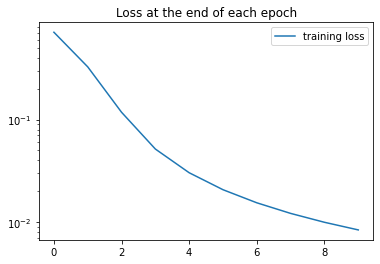

In [20]:
plt.yscale('log')
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.legend();
plt.savefig('eval_losses_2_palabras.png')

In [26]:
word = 'urjc'
torch.manual_seed(101)
image_test = 255 * np.ones(shape=[height, width], dtype = np.uint8)
image_test = cv2.putText(image_test, text = word, org = (5, 30),
fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color = (0, 0, 0),
thickness = 1, lineType = cv2.LINE_AA)

im_test = transforms.ToPILImage()(image_test) # np.ndarray to PIL.Image.Image
# encoder_input_tensor_test = torch.empty(n_patches, input_size) 

with torch.no_grad():
    
    encoder_hidden_test = Encoder_model.initHidden()

    for p in range(0, n_patches):

        im_patch_test = transforms.functional.crop(im_test, 0, 0 + p*stepsize, patch_height, patch_width) # cropping of the image into patches
        im_patch_tensor_test = transforms.ToTensor()(im_patch_test) # torch.Tensor of the patch (normalized)
        im_patch_tensor_test = 1. - im_patch_tensor_test
        # images_tensor[k + len(train_set), p, 0, :, :] = im_patch_tensor_test # assign position within the global tensor
        im_patch_tensor_test = im_patch_tensor_test.cuda()
        im_patch_tensor_test = im_patch_tensor_test.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)


        encoder_input_test = CNN_model(im_patch_tensor_test) # 1024-length vector associated to patch p (i.e. CNN output, Encoder input)
        #encoder_input_tensor_test[p,:] = encoder_input_test # we store each output in a CNN output tensor (92x1024)

        encoder_output_test, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test)

    decoder_input_test = letter_to_vector('SOS_token').cuda()
    decoder_hidden_test = encoder_hidden_test

    for d in range(len(list(word))):

        decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test)
        
        #decoder_input_test = decoder_output_test.cuda()
        #decoder_input_test = letter_to_vector(list(word)[d]).cuda()

        categorical_decoder_output_test = torch.zeros(1, 1, output_size).cuda()
        categorical_decoder_output_test[0][0][torch.argmax(decoder_output_test)] = 1.
        decoder_input_test = categorical_decoder_output_test
        
        if torch.equal(categorical_decoder_output_test, letter_to_vector('EOS_token').cuda()) == True:
            break

        if d == 0:

            output_word_test = decoder_output_test # torch vector associated to the first output letter                
            real_word_test = letter_to_vector(list(word)[d]).type(torch.LongTensor).cuda() 
            ground_word_test = torch.tensor([torch.argmax(real_word_test)]).type(torch.LongTensor).cuda() 
            # torch vector associated to the first real letter

        else:

            output_word_test = torch.cat((output_word_test, decoder_output_test), dim = 0) # we concatenate the remaining output letters
            real_word_test = torch.cat((real_word_test, 
                                   letter_to_vector(list(word)[d]).type(torch.LongTensor).cuda()), dim = 0)
            ground_word_test = torch.cat((ground_word_test,
                                    torch.tensor([torch.argmax(letter_to_vector(list(word)[d]).type(torch.LongTensor))]).cuda()), 
                                    dim = 0)
            
print(output_word_test)
model_word = []
indices = torch.argmax(output_word_test, dim = 1)
print(indices)

for i in range(indices.numel()):
    model_word.append(letters[indices[i]])
      
model_word = ''.join(model_word)
print(model_word)

tensor([[-2.1377e+01, -1.3229e+01, -3.1854e+01, -2.5503e+01, -2.1495e+01,
         -2.1070e+01, -2.1964e+01, -6.1174e+00, -2.1113e+01, -2.1587e+01,
         -1.7754e+01, -2.1434e+01, -2.1393e+01, -2.1661e+01, -2.1507e+01,
         -2.1649e+01, -2.0999e+01, -2.1768e+01, -5.7797e+00, -2.1456e+01,
         -2.1479e+01, -5.3101e-03, -2.4700e+01, -2.1744e+01, -2.1573e+01,
         -2.1654e+01, -2.1771e+01, -2.1719e+01],
        [-1.5872e+01, -8.2379e+00, -2.5109e+01, -1.4734e+01, -1.6143e+01,
         -1.5690e+01, -1.6523e+01, -1.0360e+01, -1.5529e+01, -1.6572e+01,
         -5.5352e+00, -1.5830e+01, -1.6086e+01, -1.6113e+01, -1.6164e+01,
         -1.5897e+01, -1.5663e+01, -1.6265e+01, -7.1354e-03, -1.5943e+01,
         -1.6298e+01, -5.8559e+00, -1.2989e+01, -1.6581e+01, -1.6328e+01,
         -1.5934e+01, -1.6181e+01, -1.6153e+01],
        [-1.5357e+01, -9.7732e+00, -1.8727e+01, -6.2725e+00, -1.5596e+01,
         -1.5431e+01, -1.5848e+01, -2.0714e+01, -1.5123e+01, -1.6343e+01,
         -7.02